In [1]:
import pandas as pd
import numpy as np

In [109]:
#file_path = "gs://cloud-ai-platform-5734b953-00ea-4818-b5b7-3420cd51a628/salaries_new.csv"
df= pd.read_csv('/content/salaries_new.csv')
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,data engineer,196000,USD,196000,US,0,US,M
1,2023,SE,FT,data engineer,121000,USD,121000,US,0,US,M
2,2023,MI,FT,data analyst,65000,USD,65000,US,100,US,M
3,2023,MI,FT,data analyst,55000,USD,55000,US,100,US,M
4,2023,SE,FT,machine learning engineer,220000,USD,220000,US,100,US,M


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3378 entries, 0 to 3377
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3378 non-null   int64 
 1   experience_level    3378 non-null   object
 2   employment_type     3378 non-null   object
 3   job_title           3378 non-null   object
 4   salary              3378 non-null   int64 
 5   salary_currency     3378 non-null   object
 6   salary_in_usd       3378 non-null   int64 
 7   employee_residence  3378 non-null   object
 8   remote_ratio        3378 non-null   int64 
 9   company_location    3378 non-null   object
 10  company_size        3378 non-null   object
dtypes: int64(4), object(7)
memory usage: 290.4+ KB


# Data Preprocessing

In [111]:
!pip install -q pycountry-convert

In [112]:
import pycountry_convert as pc

def get_continent(col):
    try:
        if len(col) == 2:
            country_code = col
        else:
            country_code = pc.country_name_to_country_alpha2(col.strip('\'"'))
        continent_name = pc.convert_continent_code_to_continent_name(pc.country_alpha2_to_continent_code(country_code))
        return continent_name
    except:
        return None

df['company_location']=df['company_location'].apply(lambda x: get_continent(x))
df['employee_residence']=df['employee_residence'].apply(lambda x: get_continent(x))



In [113]:
columns_to_drop = ['salary', 'salary_currency','remote_ratio']
new_df=df.drop(columns=columns_to_drop)
new_df.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,company_location,company_size
0,2023,SE,FT,data engineer,196000,North America,North America,M
1,2023,SE,FT,data engineer,121000,North America,North America,M
2,2023,MI,FT,data analyst,65000,North America,North America,M
3,2023,MI,FT,data analyst,55000,North America,North America,M
4,2023,SE,FT,machine learning engineer,220000,North America,North America,M


In [114]:
def remove_outliers(df, column_name, threshold=1.5):
    Q1 = new_df[column_name].quantile(0.25)
    Q3 = new_df[column_name].quantile(0.75)
    
    IQR = Q3 - Q1
    
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    
    filtered_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    
    return filtered_df
new_df = remove_outliers(new_df, 'salary_in_usd')
new_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3331 entries, 0 to 3377
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3331 non-null   int64 
 1   experience_level    3331 non-null   object
 2   employment_type     3331 non-null   object
 3   job_title           3331 non-null   object
 4   salary_in_usd       3331 non-null   int64 
 5   employee_residence  3331 non-null   object
 6   company_location    3331 non-null   object
 7   company_size        3331 non-null   object
dtypes: int64(2), object(6)
memory usage: 234.2+ KB


## Determining Salary Ranges


In [170]:
max_salary = new_df['salary_in_usd'].max()
min_salary = new_df['salary_in_usd'].min()

num_subranges = 15

subranges = np.linspace(min_salary, max_salary, num=num_subranges+1, endpoint=True)
range_labels = []
for i in range(len(subranges)-1):
     subrange_min = int(subranges[i])
     subrange_max = int(subranges[i+1])
     range_label = f"{subrange_min:,} - {subrange_max:,}"
     range_labels.append(range_label)

range_labels

['15,000 - 33,066',
 '33,066 - 51,133',
 '51,133 - 69,200',
 '69,200 - 87,266',
 '87,266 - 105,333',
 '105,333 - 123,400',
 '123,400 - 141,466',
 '141,466 - 159,533',
 '159,533 - 177,600',
 '177,600 - 195,666',
 '195,666 - 213,733',
 '213,733 - 231,800',
 '231,800 - 249,866',
 '249,866 - 267,933',
 '267,933 - 286,000']

In [116]:

categorical_cols=['experience_level','employment_type','job_title','company_size','employee_residence','company_location']
encoded_df = pd.get_dummies(new_df[categorical_cols], prefix=categorical_cols, prefix_sep='_')
df_encoded = pd.concat([new_df.drop(categorical_cols, axis=1), encoded_df], axis=1)
df_encoded.head()

,work_year,salary_in_usd,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,...,employee_residence_Europe,employee_residence_North America,employee_residence_Oceania,employee_residence_South America,company_location_Africa,company_location_Asia,company_location_Europe,company_location_North America,company_location_Oceania,company_location_South America
0,2023,196000,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
1,2023,121000,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
2,2023,65000,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
3,2023,55000,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
4,2023,220000,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0


In [117]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3331 entries, 0 to 3377
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   work_year                            3331 non-null   int64
 1   salary_in_usd                        3331 non-null   int64
 2   experience_level_EN                  3331 non-null   uint8
 3   experience_level_EX                  3331 non-null   uint8
 4   experience_level_MI                  3331 non-null   uint8
 5   experience_level_SE                  3331 non-null   uint8
 6   employment_type_CT                   3331 non-null   uint8
 7   employment_type_FL                   3331 non-null   uint8
 8   employment_type_FT                   3331 non-null   uint8
 9   employment_type_PT                   3331 non-null   uint8
 10  job_title_data analyst               3331 non-null   uint8
 11  job_title_data engineer              3331 non-null   uin

In [118]:
df_encoded_ = pd.get_dummies(df_encoded['work_year'], prefix='year')
df_encoded_f = pd.concat([df_encoded, df_encoded_], axis=1)
df_encoded_f.head()

,work_year,salary_in_usd,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,...,company_location_Africa,company_location_Asia,company_location_Europe,company_location_North America,company_location_Oceania,company_location_South America,year_2020,year_2021,year_2022,year_2023
0,2023,196000,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
1,2023,121000,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
2,2023,65000,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
3,2023,55000,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
4,2023,220000,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1


In [119]:
df_encoded_f=df_encoded_f.drop('work_year',axis=1)

df_encoded_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3331 entries, 0 to 3377
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   salary_in_usd                        3331 non-null   int64
 1   experience_level_EN                  3331 non-null   uint8
 2   experience_level_EX                  3331 non-null   uint8
 3   experience_level_MI                  3331 non-null   uint8
 4   experience_level_SE                  3331 non-null   uint8
 5   employment_type_CT                   3331 non-null   uint8
 6   employment_type_FL                   3331 non-null   uint8
 7   employment_type_FT                   3331 non-null   uint8
 8   employment_type_PT                   3331 non-null   uint8
 9   job_title_data analyst               3331 non-null   uint8
 10  job_title_data engineer              3331 non-null   uint8
 11  job_title_data scientist             3331 non-null   uin

# Model Fitting

In [120]:

from sklearn.model_selection import train_test_split

X = df_encoded_f.drop('salary_in_usd', axis=1)
y = df_encoded_f['salary_in_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Linear Regression

In [145]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 3.6314917931948435e+34
Mean Absolute Error (MAE): 4.781941531924729e+16
R-squared (R2) Score: -1.2499545536874454e+25


## Ridge Regression

In [160]:
param_grid = {'alpha': [0.1, 1.0, 10.0],
              
              'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}


rig = Ridge()
grid_search = GridSearchCV(rig, param_grid, scoring='r2', cv=10)

grid_search.fit(X_train, y_train)
best_ridge = grid_search.best_estimator_

y_pred = best_ridge.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)
     

Mean Squared Error (MSE): 1365411030.7595263
Mean Absolute Error (MAE): 28791.85580160383
R-squared (R2) Score: 0.5300273736674345


## Gradient Boosting

In [123]:
from sklearn.ensemble import GradientBoostingRegressor
GBreg = GradientBoostingRegressor(n_estimators = 100, random_state = 1, learning_rate=0.1, max_depth=3)
GBreg.fit(X_train, y_train)
y_pred = GBreg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 1445811633.0657322
Mean Absolute Error (MAE): 29500.942832822737
R-squared (R2) Score: 0.5023535953154691


## Kernel Ridge 

In [124]:
from sklearn.kernel_ridge import KernelRidge
KernelRidge_model = KernelRidge(alpha=0.0001)
KernelRidge_model.fit(X_train, y_train)
y_pred = KernelRidge_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)


Mean Squared Error (MSE): 1447939399.049659
Mean Absolute Error (MAE): 29622.524640361407
R-squared (R2) Score: 0.5016212211474276


## Random Forest

In [125]:
from sklearn.ensemble import RandomForestRegressor
rand_forest_model = RandomForestRegressor()
rand_forest_model.fit(X_train, y_train)
y_pred = rand_forest_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 1501013592.7292106
Mean Absolute Error (MAE): 29911.13105525479
R-squared (R2) Score: 0.48335315561101033


## XG Boost

In [152]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001]
}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=10, scoring='r2')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

best_xgb_model.fit(X_train, y_train)
y_pred = best_xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 1442648183.390657
Mean Absolute Error (MAE): 29409.757452328522
R-squared (R2) Score: 0.5034424504064074


## LightGBM

In [153]:
import lightgbm as lgb
lgb_model = lgb.LGBMRegressor()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001]
}
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=10, scoring='r2')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_lgb_model = grid_search.best_estimator_
y_pred = best_lgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 1451365590.1331263
Mean Absolute Error (MAE): 29288.113789171577
R-squared (R2) Score: 0.5004419308197974


In [146]:
!pip install -q catboost 


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.0 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor

param_grid = {'iterations': [100, 200, 300],
              'depth': [4, 6, 8],
              'learning_rate': [0.1, 0.01, 0.001]}

catboost = CatBoostRegressor()

grid_search = GridSearchCV(catboost, param_grid, scoring='r2', cv=10)

grid_search.fit(X_train, y_train)

best_catboost = grid_search.best_estimator_

y_pred = best_catboost.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)


In [161]:
model=best_ridge
model

Ridge(alpha=10.0, solver='lsqr')

In [155]:
feature_names = X_train.columns
feature_names

Index(['experience_level_EN', 'experience_level_EX', 'experience_level_MI',
       'experience_level_SE', 'employment_type_CT', 'employment_type_FL',
       'employment_type_FT', 'employment_type_PT', 'job_title_data analyst',
       'job_title_data engineer', 'job_title_data scientist',
       'job_title_machine learning engineer', 'company_size_L',
       'company_size_M', 'company_size_S', 'employee_residence_Africa',
       'employee_residence_Asia', 'employee_residence_Europe',
       'employee_residence_North America', 'employee_residence_Oceania',
       'employee_residence_South America', 'company_location_Africa',
       'company_location_Asia', 'company_location_Europe',
       'company_location_North America', 'company_location_Oceania',
       'company_location_South America', 'year_2020', 'year_2021', 'year_2022',
       'year_2023'],
      dtype='object')

(31,)


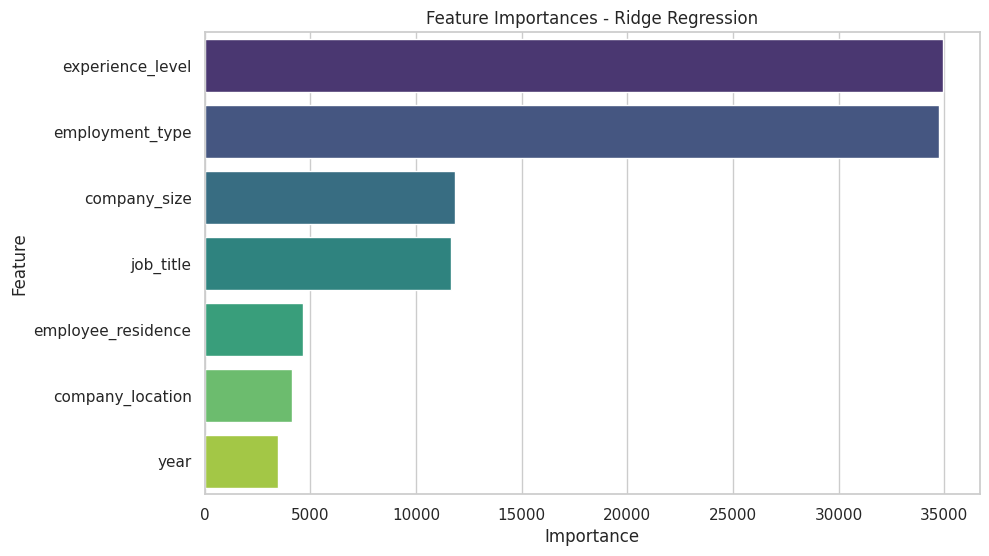

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
feature_importances = np.abs(model.coef_)  
print(feature_importances.shape)

original_feature_names = 'experience_level','employment_type','job_title','company_size','year','company_location','employee_residence'

if feature_importances.shape[0] != len(original_feature_names):
    feature_importances = feature_importances[:len(original_feature_names)]

importance_df = pd.DataFrame({'Feature': original_feature_names, 'Importance': feature_importances})
importance_df = importance_df.groupby('Feature', as_index=False).sum()
importance_df = importance_df.sort_values('Importance', ascending=False)
 
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances - Ridge Regression')
plt.show()

## Making Predictions

In [166]:
import joblib
import numpy as np

def make_prediction(feature_values):
    feature_names = ['experience_level_EN', 'experience_level_EX', 'experience_level_MI',
                     'experience_level_SE','employment_type_CT', 'employment_type_FL', 'employment_type_FT',
                     'employment_type_PT', 'job_title_data engineer','job_title_data analyst',
                     'job_title_data scientist', 'job_title_machine learning engineer',
                     'company_size_M', 'company_size_S', 'company_size_L','employee_residence_Africa',
                     'employee_residence_Asia', 'employee_residence_Europe',
                     'employee_residence_North America', 'employee_residence_Oceania',
                     'employee_residence_South America', 'company_location_Africa',
                     'company_location_Asia', 'company_location_Europe',
                     'company_location_North America', 'company_location_Oceania',
                     'company_location_South America', 'year_2020', 'year_2021',
                     'year_2022', 'year_2023']

    # Create a numpy array for the input data
    input_data = np.array([[feature_values['employee_residence'] == 'Africa',
                            feature_values['employee_residence'] == 'Asia',
                            feature_values['employee_residence'] == 'Europe',
                            feature_values['employee_residence'] == 'North America',
                            feature_values['employee_residence'] == 'Oceania',
                            feature_values['employee_residence'] == 'South America',
                            feature_values['company_location'] == 'Africa',
                            feature_values['company_location'] == 'Asia',
                            feature_values['company_location'] == 'Europe',
                            feature_values['company_location'] == 'North America',
                            feature_values['company_location'] == 'Oceania',
                            feature_values['company_location'] == 'South America',
                            feature_values['experience_level'] == 'EN',
                            feature_values['experience_level'] == 'EX',
                            feature_values['experience_level'] == 'MI',
                            feature_values['experience_level'] == 'SE',
                            feature_values['employment_type'] == 'CT',
                            feature_values['employment_type'] == 'FL',
                            feature_values['employment_type'] == 'FT',
                            feature_values['employment_type'] == 'PT',
                            feature_values['job_title'] == 'data analyst',
                            feature_values['job_title'] == 'data engineer',
                            feature_values['job_title'] == 'data scientist',
                            feature_values['job_title'] == 'machine learning engineer',
                            feature_values['company_size'] == 'M',
                            feature_values['company_size'] =='S',
                            feature_values['company_size'] =='L',
                            feature_values['year'] == 2020,
                            feature_values['year'] == 2021,
                            feature_values['year'] == 2022,
                            feature_values['year'] == 2023]])
    prediction = model.predict(input_data)

    ranges = [(15000 , 48875),
              (48875 , 82750),
              (82750 , 116625),
              (116625 , 150500),
              (150500 , 184375),
              (184375 , 218250),
              (218250 , 252125),
              (252125 , 286000)]
    prediction_range = None
    for range_min, range_max in ranges:
        if range_min <= prediction < range_max:
            prediction_range = f"{range_min:,} - {range_max:,}"
            break

    return prediction_range


input_features = {
    
    'experience_level': 'EX',
    'employment_type': 'FL',
    'job_title': 'data scientist',
    'year': 2023,
    'company_size': 'L',
    'employee_residence': 'Europe',
    'company_location' :'Europe',
}

prediction = make_prediction( input_features)

print("Prediction:", prediction)


Prediction: 15,000 - 48,875


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


In [173]:
import joblib
import pickle
with open('sal_model_V4.pkl', 'wb') as f:
    pickle.dump(model, f)

from google.colab import files
files.download('sal_model_V4.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.cloud import storage
import pickle

# Create a storage client
storage_client = storage.Client()

# Replace 'your-bucket-name' with the name of your Cloud Storage bucket
bucket = storage_client.bucket('cloud-ai-platform-5734b953-00ea-4818-b5b7-3420cd51a628')

# Replace 'model.pkl' with the desired name for the saved model file
blob = bucket.blob('sal_model_V2.pkl')

# Save the trained model to a local file in pickle format
with open('sal_model_V2.pkl', 'wb') as f:
    pickle.dump(model, f)

# Upload the saved model file to Cloud Storage
blob.upload_from_filename('sal_model_V2.pkl')


In [ ]:
from google.cloud import storage

# Replace 'your-bucket-name' with the name of your Cloud Storage bucket
BUCKET_NAME = 'cloud-ai-platform-5734b953-00ea-4818-b5b7-3420cd51a628'

# Replace 'notebook.ipynb' with the name of your Jupyter notebook
NOTEBOOK_NAME = 'salary_pred_model.ipynb'

# Create a storage client
storage_client = storage.Client()

# Get a reference to your Cloud Storage bucket
bucket = storage_client.bucket(BUCKET_NAME)

# Get a reference to a blob in the bucket
blob = bucket.blob(NOTEBOOK_NAME)

# Upload the Jupyter notebook to Cloud Storage
blob.upload_from_filename(NOTEBOOK_NAME)
